<a href="https://colab.research.google.com/github/simranvanjani/Personal-projects/blob/main/Loan_Eligibility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Algorithms

## Business Case
**Problem Statement**

A Bank wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. 
These details are given below. 

To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. 



#### 1. Import Data

In [ ]:
from pandas import read_csv
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sc
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm 
from sklearn.feature_selection import mutual_info_classif

In [ ]:
dfcl = read_csv(
    "train_DSC-M2-D7-L7.csv")
dfcl.head()

,Loan_ID,Loan_Status,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,1,Male,No,0,Graduate,No,5849,0.0,-1,360,1,Urban
1,LP001003,0,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural
2,LP001005,1,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban
3,LP001006,1,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,1,Urban
4,LP001008,1,Male,No,0,Graduate,No,6000,0.0,141,360,1,Urban


###  Data Preperation

**Case of categorical variable interaction.**

As we can see there are many categorical variables. Multicollinearity of them is not statistically valid. 
However, There may be redundant categorical columns which might impact logistic regression. 
To eliminate it, Pearson's correlation is ineffective.

Hence there are following methods used with thier limitations.

| |Method|Limitations|
|:-|:----|:----------|
|1|Spearman Rank Correlation|any Rank correlation only works with Ordinal variables|
|2|VIF|VIF gives higher values for `nominal variables with categories > 5 and discrete variables`,  which might suggest elimination. Hence care needs to taken.|
|3|Mutual Information| It is good for all categorical variables, but not discrete variables and it can only be used with two variables at a time. Multivariable interaction need more complex coding|

In [ ]:
#Let us factorize data (we have  binary and nominal categorical variables )
ncols=dfcl.columns
for cols in ncols:
    dfcl[cols],unique=pd.factorize(dfcl[cols])

In [ ]:
print(dfcl.nunique())
x=dfcl.drop(columns=["Loan_ID"])
# We will use VIF but VIF is not useful with discrete non-ordinal variables like LoanAmount and Loan_Amount_Term. It will give high VIF for them, which we will ignore
def vifcal(x):
#     Calculating VIF
    vif = pd.DataFrame()
    vif["Features"] = x.columns
    vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return(vif)
    
vifcal(x)



Loan_ID              614
Loan_Status            2
Gender                 3
Married                3
Dependents             4
Education              2
Self_Employed          3
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           204
Loan_Amount_Term      11
Credit_History         3
Property_Area          3
dtype: int64


,Features,VIF
0,Loan_Status,1.535680
1,Gender,1.296131
2,Married,2.912213
3,Dependents,1.898343
4,Education,1.313336
5,Self_Employed,1.169587
6,ApplicantIncome,3.986918
7,CoapplicantIncome,2.228462
8,LoanAmount,3.019496
9,Loan_Amount_Term,1.190993


In [ ]:
#let us write interaction function for MI
MI=np.ndarray((len(cols),len(cols)))
def interaction_mi(xdf,N) :
    cols=xdf.columns.to_list()
    MI=np.ndarray((len(cols),len(cols)))
    xdf_MI = pd.DataFrame(columns=cols)
    xdf_MI=xdf_MI.astype('float64')
    for i in range(xdf.shape[1]):
        MI[i]=mutual_info_classif(xdf,xdf.iloc[:,i],n_neighbors=N)
        x=MI.tolist()
        y=pd.Series(index=cols,name=xdf.columns[i],data=np.round(x[i],decimals=1))
        xdf_MI=xdf_MI.append(y)
    return(xdf_MI)

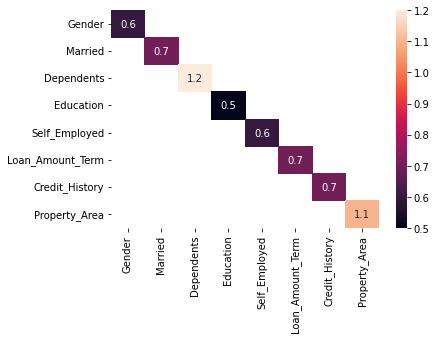

In [ ]:
#Let us test data for interaction
dfcl_fr=dfcl.drop(columns=["Loan_Status","Loan_ID","ApplicantIncome","CoapplicantIncome","LoanAmount"])
dfcl_M=interaction_mi(dfcl_fr,3)

p=dfcl_M[dfcl_M[dfcl_M.columns] > 0.1]  
sns.heatmap(p, annot=True)
plt.show()

It is good to see that no categorical variables are interacting.

In [ ]:
#Encode all categorical variables.
dfcl_onehot = pd.get_dummies(dfcl, prefix_sep="__",
                              columns=["Gender","Married","Education","Self_Employed","Credit_History","Property_Area"])
ncols=["Gender","Married","Education","Self_Employed","Credit_History","Property_Area"]

#### 3. Split Dataset into train and test datasets

In [ ]:
dfcl_train, dfcl_test = train_test_split(dfcl_onehot, test_size=0.3)
dfcl_train_LID = dfcl_train.filter(["Loan_ID"])
dfcl_train = dfcl_train.drop(columns="Loan_ID")
dfcl_test_LID = dfcl_test.filter(["Loan_ID"])
dfcl_test = dfcl_test.drop(columns="Loan_ID")
dfcl_train.head(10)

,Loan_Status,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender__0,Gender__1,Gender__2,Married__0,...,Education__1,Self_Employed__0,Self_Employed__1,Self_Employed__2,Credit_History__0,Credit_History__1,Credit_History__2,Property_Area__0,Property_Area__1,Property_Area__2
12,0,2,12,10,12,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
280,1,1,246,144,7,0,1,0,0,1,...,1,0,1,0,0,1,0,1,0,0
13,1,0,13,11,13,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
88,0,0,76,0,62,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
308,1,0,265,0,139,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
81,0,1,72,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
502,0,2,417,236,180,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
61,0,3,58,0,46,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
253,0,1,221,132,126,4,1,0,0,0,...,1,1,0,0,1,0,0,0,0,1
530,0,0,349,254,70,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0


**Balanced data**

We check dataset for balanced data i.e.it has equal samples for all the classes).
Unbalanced data, i.e. data that has more samples for one class than others, can make the classifier biased toward the one or two classes with lots of samples, while dwarfing others that have less.
i.e. the classifier learns the classes with more samples better and remains weak on the smaller classes.
Let us check target variable for class balance.

In [ ]:
dfcl_train.Loan_Status.value_counts()


0    291
1    138
Name: Loan_Status, dtype: int64

Our dataset is unbalanced as it has more samples for 1 class(295) than 0 class(134). 

There are various ways data can be balanced as below:

Subsampling: Taking a smaller yet equal selection of samples from each class. 

Upsampling: Taking repeat samples from some classes to increase its numbers.

Resampling : using an algorithm like SMOTE to augment the dataset with artificial data.

In [ ]:
# Let us balance train data frame using resampling
from sklearn.utils import resample

In [ ]:
# Separate majority and minority classes
dfcl_train_majority = dfcl_train[dfcl_train.Loan_Status==0]
dfcl_train_minority = dfcl_train[dfcl_train.Loan_Status==1]
 
### 1. Upsample minority class
dfcl_train_minority_upsampled = resample(dfcl_train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=295,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
dfcl_train_upsampled = pd.concat([dfcl_train_majority, dfcl_train_minority_upsampled])
 
# Display new class counts
dfcl_train_upsampled.Loan_Status.value_counts()

### 2.  subsample minority class
dfcl_train_majority_subsampled = resample(dfcl_train_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=134,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
dfcl_train_subsampled = pd.concat([dfcl_train_majority_subsampled, dfcl_train_minority])
 
# Display new class counts
dfcl_train_subsampled.Loan_Status.value_counts()

1    138
0    134
Name: Loan_Status, dtype: int64

In [ ]:
dfcl_train_upsampled.columns

Index(['Loan_Status', 'Dependents', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Loan_Amount_Term', 'Gender__0', 'Gender__1', 'Gender__2',
       'Married__0', 'Married__1', 'Married__2', 'Education__0',
       'Education__1', 'Self_Employed__0', 'Self_Employed__1',
       'Self_Employed__2', 'Credit_History__0', 'Credit_History__1',
       'Credit_History__2', 'Property_Area__0', 'Property_Area__1',
       'Property_Area__2'],
      dtype='object')

# Scaling the Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()

In [ ]:
dfcl_train_upsampled_minmax=minmax.fit_transform(dfcl_train_upsampled)
df1=pd.DataFrame(dfcl_train_upsampled_minmax,columns=(['Loan_Status', 'Dependents', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Loan_Amount_Term', 'Gender__0', 'Gender__1', 'Gender__2',
       'Married__0', 'Married__1', 'Married__2', 'Education__0',
       'Education__1', 'Self_Employed__0', 'Self_Employed__1',
       'Self_Employed__2', 'Credit_History__0', 'Credit_History__1',
       'Credit_History__2', 'Property_Area__0', 'Property_Area__1',
       'Property_Area__2']))
df1

,Loan_Status,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender__0,Gender__1,Gender__2,Married__0,...,Education__1,Self_Employed__0,Self_Employed__1,Self_Employed__2,Credit_History__0,Credit_History__1,Credit_History__2,Property_Area__0,Property_Area__1,Property_Area__2
0,0.0,0.666667,0.023810,0.035211,0.059406,0.000000,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.000000,0.150794,0.000000,0.306931,0.000000,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.333333,0.142857,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.666667,0.827381,0.830986,0.891089,0.000000,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.000000,0.115079,0.000000,0.227723,0.000000,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,1.0,0.000000,0.573413,0.000000,0.960396,0.000000,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
582,1.0,0.000000,0.376984,0.390845,0.217822,0.000000,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
583,1.0,0.000000,0.053571,0.000000,0.138614,0.000000,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
584,1.0,0.000000,0.039683,0.000000,0.099010,0.000000,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
dfcl_test_upsampled_minmax=minmax.fit_transform(dfcl_test)
df2=pd.DataFrame(dfcl_test_upsampled_minmax,columns=(['Loan_Status', 'Dependents', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Loan_Amount_Term', 'Gender__0', 'Gender__1', 'Gender__2',
       'Married__0', 'Married__1', 'Married__2', 'Education__0',
       'Education__1', 'Self_Employed__0', 'Self_Employed__1',
       'Self_Employed__2', 'Credit_History__0', 'Credit_History__1',
       'Credit_History__2', 'Property_Area__0', 'Property_Area__1',
       'Property_Area__2']))

In [ ]:
dfcl_test

,Loan_Status,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender__0,Gender__1,Gender__2,Married__0,...,Education__1,Self_Employed__0,Self_Employed__1,Self_Employed__2,Credit_History__0,Credit_History__1,Credit_History__2,Property_Area__0,Property_Area__1,Property_Area__2
505,0,2,17,234,181,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
120,0,3,107,73,45,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
550,1,2,458,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
174,1,0,153,94,98,0,1,0,0,0,...,1,0,1,0,1,0,0,0,0,1
164,0,0,144,0,37,4,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0,0,103,0,132,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
222,0,0,196,115,33,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
192,1,0,169,0,68,0,1,0,0,0,...,1,1,0,0,1,0,0,1,0,0
458,0,2,383,0,51,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0


In [ ]:
#split X and y for test and train
y_dfcl_train = df1.filter(["Loan_Status"])
x_dfcl_train = df1.drop(columns = ["Loan_Status"])
y_dfcl_test = df2.filter(["Loan_Status"])
x_dfcl_test = df2.drop(columns = ["Loan_Status"])

In [ ]:
x_dfcl_train.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender__0,Gender__1,Gender__2,Married__0,Married__1,...,Education__1,Self_Employed__0,Self_Employed__1,Self_Employed__2,Credit_History__0,Credit_History__1,Credit_History__2,Property_Area__0,Property_Area__1,Property_Area__2
count,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.00000,586.000000,586.000000,586.000000,...,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000
mean,0.283276,0.458266,0.245385,0.358548,0.086841,0.784983,0.18430,0.030717,0.378840,0.617747,...,0.244027,0.810580,0.131399,0.058020,0.715017,0.191126,0.093857,0.380546,0.295222,0.324232
std,0.364832,0.292915,0.314357,0.276981,0.207389,0.411185,0.38806,0.172697,0.485513,0.486353,...,0.429876,0.392176,0.338125,0.233982,0.451792,0.393524,0.291878,0.485936,0.456532,0.468487
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.204861,0.000000,0.128713,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.450397,0.038732,0.287129,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.691964,0.481514,0.589109,0.000000,1.000000,0.00000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


So we are ready to use Logistic Regression.

## A. Logistic Regression

#### 4. Initialize and fit logistic regression algorithm to training dataset

This is the original model

In [ ]:
log_reg1= LogisticRegression(max_iter=2000,solver="lbfgs")
log_reg1.fit(x_dfcl_train,y_dfcl_train)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=2000)

#GridSearch

In [ ]:
#GridSearchCV
new_log1=LogisticRegression()
grid_param=[
    {'penalty':['l1','l2','elasticnet','none'],
    'solver':['lbfgs','newton-cg','liblinear','sag','saga'],
    'C':np.logspace(-10,10,20),
    'max_iter':[100,500,1000,2000,5000]}
]

from sklearn.model_selection import GridSearchCV
grid_model=GridSearchCV(new_log1,param_grid=grid_param,cv=4,verbose=True,n_jobs=-1)
grid_model_fit=grid_model.fit(x_dfcl_train,y_dfcl_train)

Fitting 4 folds for each of 2000 candidates, totalling 8000 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3600 fits failed out of a total of 8000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: S

#Randomsearch

In [ ]:
new_log_Random1=LogisticRegression()
random_param=[
    {'penalty':['l1','l2','none'],
    'solver':['lbfgs','newton-cg','liblinear','sag','saga'],
    'C':np.logspace(-4,4,20)
    }
]

from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = RandomizedSearchCV(estimator = new_log_Random1, param_distributions = random_param,n_iter=100, 
                               cv =3, verbose= 1, random_state= 101, n_jobs = -1)

In [ ]:
model_random_fit=model.fit(x_dfcl_train,y_dfcl_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is n

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier()
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [20]}



RF_grid=GridSearchCV( RF, param_grid = random_search, cv = 4, verbose= 1, n_jobs = -1)
RF_grid_best_fit=RF_grid.fit(x_dfcl_train,y_dfcl_train.values.ravel())

Fitting 4 folds for each of 36 candidates, totalling 144 fits


### Determining accuracy of model
#### 5. Accuracy score from model

In [ ]:
sc = log_reg1.score(x_dfcl_test,y_dfcl_test)
print(sc)
# Is our model still predicting just one class?

# [0 1]
 #print(log_reg.coef_)
#print("intercepts :",log_reg.intercept_)

0.8


In [ ]:
#For GridSearchCV
sc_gs = grid_model_fit.score(x_dfcl_test,y_dfcl_test)
print(sc_gs)

0.7945945945945946


In [ ]:
#For RandomizedSearchCV
sc_random=model_random_fit.score(x_dfcl_test,y_dfcl_test)
print(sc_random)

0.8054054054054054


#accuracy score for various types of models shows that highest accurcy that can be achieved is 0.8054054054054054. Logistic regression gives score of 0.8. 

# Result of Regression Optimisation

#### 6. Calculate Deviance

Deviance is closely related to cross entropy, which is log_loss in sklearn.metrics.log_loss. 

Deviance = 2*(loglikelihood_of_saturated_model - loglikelihood of fitted model)

Scikit learn can (without larger tweaks) only handle classification of individual instances, so that the log-likelihood of the saturated model is going to be zero. 

Cross entropy as returned by log_loss is the negative log-likelihood. Thus, the deviance is simply 2*log_loss(x,y)

In [ ]:
from sklearn.metrics import log_loss
deviance = 2*log_loss(y_dfcl_train, grid_model_fit.predict_log_proba(x_dfcl_train))
print("Deviance :", deviance)

Deviance : 1.3862943611198906


#### 7. Measure Accuracy performance of classification

 AUC for ROC should be >= 0.5

In [ ]:
def model_perf(x,y,model):
    # 1. Confusion Metrics
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y, model.predict(x))
    print(confusion_matrix)
    # 2. Compute Precision, Recall and F-score
    from sklearn.metrics import classification_report
    reprt = classification_report(y, model.predict(x),output_dict=True)
    class_rep = pd.DataFrame(data=reprt)
    print(class_rep)
    # 3. Plot ROC curve and Compute AUC
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    cls_roc_auc = roc_auc_score(y, model.predict(x))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x)[:,1])
    print("AUC :",cls_roc_auc)
    plt.figure()
    plt.plot(fpr, tpr, label='AUC = %0.2f' % cls_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

[[109  22]
 [ 15  39]]
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.879032   0.639344       0.8    0.759188      0.809069
recall       0.832061   0.722222       0.8    0.777142      0.800000
f1-score     0.854902   0.678261       0.8    0.766581      0.803342
support    131.000000  54.000000       0.8  185.000000    185.000000
AUC : 0.7771416454622561


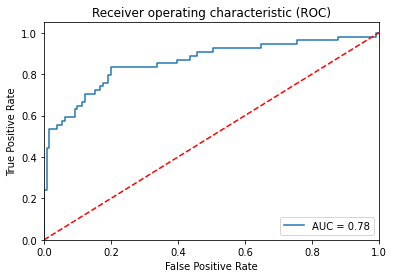

In [ ]:
model_perf(x_dfcl_test,y_dfcl_test,log_reg1)

## B. naive Bayes' Classification

#### 1. Check distribution of predictors

Since we have 3 Features that are continuos and rest are categorical we will fit GaussianNB first, 
for that we need to check their density distributions.


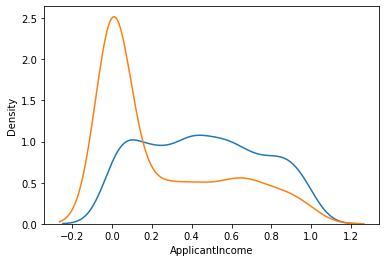

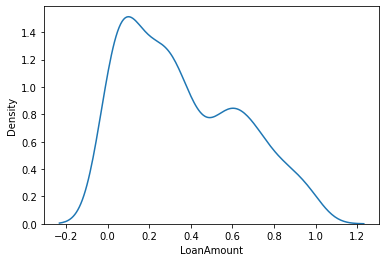

In [ ]:
sns.kdeplot(data=x_dfcl_train.ApplicantIncome)
sns.kdeplot(data=x_dfcl_train.CoapplicantIncome)
plt.show()
sns.kdeplot(data=x_dfcl_train.LoanAmount)
plt.show()

Now that we are confirm that all are nearly normally distributed let us use gaussianNB<br>


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb_cls = GaussianNB()
gnb_cls.fit(x_dfcl_train,y_dfcl_train.values.ravel())

GaussianNB()

#### 2. Measure Model Accuracy

0.5068259385665529
[[  1 130]
 [  0  54]]
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    1.000000   0.293478  0.297297    0.646739      0.793772
recall       0.007634   1.000000  0.297297    0.503817      0.297297
f1-score     0.015152   0.453782  0.297297    0.234467      0.143184
support    131.000000  54.000000  0.297297  185.000000    185.000000
AUC : 0.5038167938931297


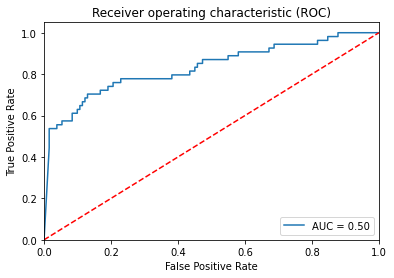

In [ ]:
print(gnb_cls.score(x_dfcl_train,y_dfcl_train))
model_perf(x_dfcl_test,y_dfcl_test,gnb_cls)
y_pred_gnb = gnb_cls.predict(x_dfcl_test)

In [ ]:
print(gnb_cls.score(x_dfcl_test,y_dfcl_test))

0.2972972972972973
